In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
ruta = "../data/WineQT.csv"
df = pd.read_csv(filepath_or_buffer=ruta, low_memory=True, sep=',')
df.shape

### 1. Carga y Exploración de Datos:

* Cargar el dataset y revisar su estructura básica.
* Describir las variables y su distribución.
* Identificar y tratar valores nulos y outliers.

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df)
plt.show()

In [ ]:
# Calcular el IQR para todas las columnas numéricas
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identificar los outliers
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# Ver las filas que contienen outliers
outliers_rows = df[df.any(axis=1)]
print(outliers_rows)


In [20]:
df_no_outliers = df[~outliers.any(axis=1)]

###  2. Preprocesamiento de Datos:

* Seleccionar características importantes para la clasificación.
* Transformar variables categóricas en variables numéricas si es necesario.
* Dividir los datos en conjuntos de entrenamiento y prueba.
* Escalar las características.

In [47]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Ver la correlación de todas las variables con la variable objetivo (quality)
print(correlation_matrix['quality'].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64


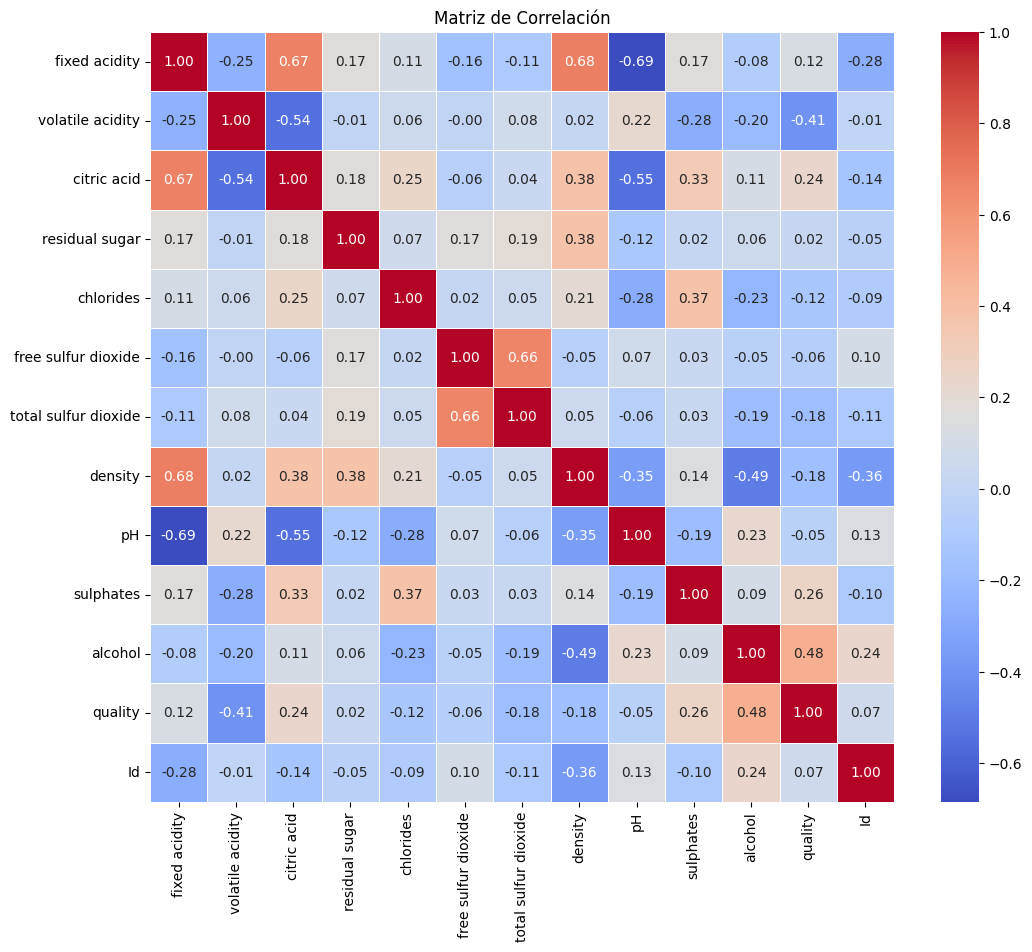

In [48]:
# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [49]:
# Dividir las características (X) y la variable objetivo (y)
X = df.drop(columns=['quality', 'Id'])
y = df['quality']

# Aplicar la prueba ANOVA F-Score
F_values, p_values = f_classif(X, y)

# Mostrar los resultados
feature_importance = pd.DataFrame({'Feature': X.columns, 'F-Value': F_values, 'p-Value': p_values})
print(feature_importance.sort_values(by='F-Value', ascending=False))

                 Feature    F-Value       p-Value
10               alcohol  82.747058  3.399896e-74
1       volatile acidity  47.937979  4.446443e-45
9              sulphates  18.049074  2.926057e-17
2            citric acid  17.705465  6.321608e-17
6   total sulfur dioxide  15.270771  1.506676e-14
7                density   8.544380  5.907001e-08
0          fixed acidity   4.314182  6.814326e-04
8                     pH   4.149650  9.687159e-04
4              chlorides   3.690383  2.562332e-03
5    free sulfur dioxide   2.692791  1.988523e-02
3         residual sugar   1.234693  2.905042e-01


In [50]:
# Entrenar un modelo RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener la importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                 Feature  Importance
10               alcohol    0.282930
9              sulphates    0.134027
1       volatile acidity    0.133582
6   total sulfur dioxide    0.070207
8                     pH    0.059963
4              chlorides    0.058024
0          fixed acidity    0.057802
2            citric acid    0.054592
7                density    0.051734
3         residual sugar    0.049908
5    free sulfur dioxide    0.047231


In [51]:
le = LabelEncoder()
df['quality'] = le.fit_transform(df['quality'])

# Ver los primeros valores transformados
print(df['quality'].head())

0    2
1    2
2    2
3    3
4    2
Name: quality, dtype: int64


In [52]:
# Definir las características (X) y la variable objetivo (y)
X = df.drop(columns=['quality', 'Id'])  # Excluimos 'quality' y 'Id' (esta última no es relevante para el modelo)
y = df['quality']

# Dividir los datos en entrenamiento y prueba (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ver el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (914, 11)
Tamaño del conjunto de prueba: (229, 11)


In [53]:
# Inicializar el estandarizador
scaler = StandardScaler()

# Ajustar el escalador solo a los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Usar el mismo escalador para transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Ver las primeras filas de las características escaladas
print(X_train_scaled[:5])

[[ 0.1426802  -1.40273053  1.5096933  -0.55102394  0.11651554  1.88559834
   1.79122276  0.11355786 -0.09314751  0.56821234  0.05661327]
 [ 0.96843134 -1.17920341  1.5096933  -0.39776844 -0.28423884 -1.24188154
  -1.18572018 -0.7017669  -1.07474038  0.4477703   0.89445566]
 [ 0.3786091  -1.23508519  0.4833938   0.06199805 -0.64280855 -0.55774532
  -0.21429669 -0.55542656  0.56124774  0.20688622  1.26683005]
 [-0.97798208  1.95017634 -1.1586854  -0.24451294 -0.43188519 -0.36227782
  -0.80968528 -0.16866994  1.41196156 -0.57598704 -0.50194833]
 [-0.38815983 -0.6203856  -0.08107092  1.0581588   0.36962357  1.20146211
   1.38385162  0.6048433  -1.07474038 -0.51576602 -1.24669712]]


In [54]:
# Inicializar el normalizador
scaler = MinMaxScaler()
# Ajustar el normalizador solo a los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
# Usar el mismo normalizador para transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)
# Ver las primeras filas de las características normalizadas
print(X_train_scaled[:5])

[[0.35454545 0.10958904 0.56       0.06164384 0.13355593 0.50746269
  0.35661765 0.52018279 0.44094488 0.25149701 0.375     ]
 [0.48181818 0.1369863  0.56       0.07534247 0.10183639 0.02985075
  0.00735294 0.40137091 0.32283465 0.23952096 0.53571429]
 [0.39090909 0.13013699 0.36       0.11643836 0.07345576 0.13432836
  0.12132353 0.42269612 0.51968504 0.21556886 0.60714286]
 [0.18181818 0.52054795 0.04       0.0890411  0.09015025 0.1641791
  0.05147059 0.4790556  0.62204724 0.13772455 0.26785714]
 [0.27272727 0.20547945 0.25       0.20547945 0.15358932 0.40298507
  0.30882353 0.59177456 0.32283465 0.14371257 0.125     ]]


### 3. Entrenamiento de Modelos de Clasificación:

* Entrenar al menos tres modelos de clasificación diferentes (por ejemplo, KNN, RandomForest, y Regresión Logística).
* Utilizar validación cruzada para seleccionar los mejores hiperparámetros.

In [41]:
# Crear el modelo KNN (aquí usamos 5 vecinos como ejemplo)
knn = KNeighborsClassifier(n_neighbors=5)

# Entrenar el modelo con los datos de entrenamiento
knn.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_knn = knn.predict(X_test_scaled)

# Evaluar el rendimiento del modelo (precisión)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Precisión del modelo KNN: {accuracy_knn:.4f}")

Precisión del modelo KNN: 0.5721


In [42]:
# Crear el modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_scaled)

# Evaluar el rendimiento del modelo (precisión)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión del modelo Random Forest: {accuracy_rf:.4f}")

Precisión del modelo Random Forest: 0.6943


In [43]:
# Crear el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=200, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
log_reg.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluar el rendimiento del modelo (precisión)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Precisión del modelo Regresión Logística: {accuracy_log_reg:.4f}")

Precisión del modelo Regresión Logística: 0.6332


In [58]:
# Definir el espacio de parámetros a explorar
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Número de vecinos
    'p': [1, 2]  # Distancia de Manhattan (1) o Euclidiana (2)
}

# Crear el modelo KNN
knn = KNeighborsClassifier()

# Crear el GridSearchCV con validación cruzada (5-folds)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search_knn.fit(X_train_scaled, y_train)

# Ver los mejores hiperparámetros y la mejor precisión
print(f"Mejores parámetros para KNN: {grid_search_knn.best_params_}")
print(f"Mejor precisión para KNN: {grid_search_knn.best_score_:.4f}")

Mejores parámetros para KNN: {'n_neighbors': 15, 'p': 1}
Mejor precisión para KNN: 0.5634


In [45]:
# Definir el espacio de parámetros a explorar
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad de los árboles
    'min_samples_split': [2, 5, 10]  # Mínimo número de muestras para dividir un nodo
}

# Crear el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Crear el GridSearchCV con validación cruzada (5-folds)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search_rf.fit(X_train_scaled, y_train)

# Ver los mejores hiperparámetros y la mejor precisión
print(f"Mejores parámetros para Random Forest: {grid_search_rf.best_params_}")
print(f"Mejor precisión para Random Forest: {grid_search_rf.best_score_:.4f}")

Mejores parámetros para Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mejor precisión para Random Forest: 0.6465


In [46]:
# Definir el espacio de parámetros a explorar
param_grid_log_reg = {
    'C': [0.1, 1, 10],  # Regularización (inverso de la penalización)
    'solver': ['liblinear', 'lbfgs']  # Algoritmos de optimización
}

# Crear el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=200, random_state=42)

# Crear el GridSearchCV con validación cruzada (5-folds)
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid_log_reg, cv=5, scoring='accuracy')

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search_log_reg.fit(X_train_scaled, y_train)

# Ver los mejores hiperparámetros y la mejor precisión
print(f"Mejores parámetros para Regresión Logística: {grid_search_log_reg.best_params_}")
print(f"Mejor precisión para Regresión Logística: {grid_search_log_reg.best_score_:.4f}")

Mejores parámetros para Regresión Logística: {'C': 10, 'solver': 'lbfgs'}
Mejor precisión para Regresión Logística: 0.5919


###  4. Evaluación de Modelos:

* Evaluar los modelos utilizando métricas como exactitud, precisión, recall, F1-Score y matriz de confusión.
* Generar un informe de clasificación para cada modelo.
* Crear y visualizar la curva ROC y calcular el AUC para el mejor modelo.

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precisión del modelo KNN: 0.5939
Precisión ponderada (KNN): 0.5687
Recall ponderado (KNN): 0.5939
F1-Score ponderado (KNN): 0.5792
Matriz de Confusión (KNN):
[[ 0  4  2  0  0]
 [ 1 67 27  1  0]
 [ 0 28 62  9  0]
 [ 0  1 18  7  0]
 [ 0  0  1  1  0]]


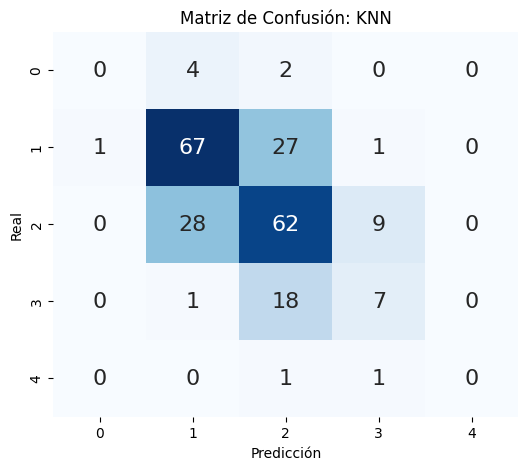


Reporte de clasificación para KNN:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.67      0.70      0.68        96
           3       0.56      0.63      0.59        99
           4       0.39      0.27      0.32        26
           5       0.00      0.00      0.00         2

    accuracy                           0.59       229
   macro avg       0.32      0.32      0.32       229
weighted avg       0.57      0.59      0.58       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [60]:
best_knn = grid_search_knn.best_estimator_
# Realizar predicciones con el modelo KNN final
y_pred_knn_final = best_knn.predict(X_test_scaled)

# Métricas de rendimiento
accuracy_knn_final = accuracy_score(y_test, y_pred_knn_final)
precision_knn_final = precision_score(y_test, y_pred_knn_final, average='weighted')
recall_knn_final = recall_score(y_test, y_pred_knn_final, average='weighted')
f1_knn_final = f1_score(y_test, y_pred_knn_final, average='weighted')

# Mostrar resultados
print(f"Precisión del modelo KNN: {accuracy_knn_final:.4f}")
print(f"Precisión ponderada (KNN): {precision_knn_final:.4f}")
print(f"Recall ponderado (KNN): {recall_knn_final:.4f}")
print(f"F1-Score ponderado (KNN): {f1_knn_final:.4f}")

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn_final)
print(f"Matriz de Confusión (KNN):\n{cm_knn}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.title('Matriz de Confusión: KNN')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación para KNN:")
print(classification_report(y_test, y_pred_knn_final))

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precisión del modelo Random Forest: 0.6900
Precisión ponderada (Random Forest): 0.6653
Recall ponderado (Random Forest): 0.6900
F1-Score ponderado (Random Forest): 0.6768
Matriz de Confusión (Random Forest):
[[ 0  3  3  0  0]
 [ 0 75 20  1  0]
 [ 0 26 67  6  0]
 [ 0  0 10 16  0]
 [ 0  0  2  0  0]]


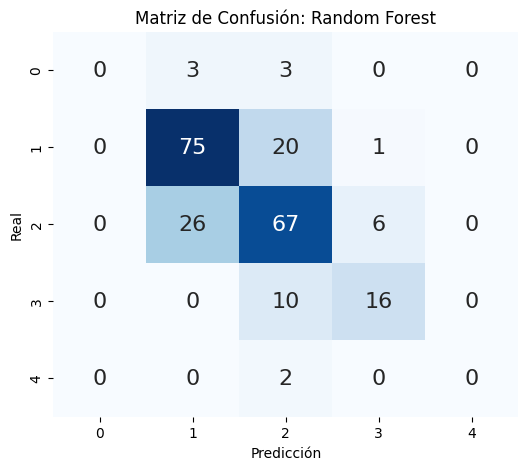


Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.72      0.78      0.75        96
           3       0.66      0.68      0.67        99
           4       0.70      0.62      0.65        26
           5       0.00      0.00      0.00         2

    accuracy                           0.69       229
   macro avg       0.41      0.41      0.41       229
weighted avg       0.67      0.69      0.68       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [62]:
# Obtener el mejor modelo (best_rf)
best_rf = grid_search_rf.best_estimator_
# Realizar predicciones con el modelo Random Forest final
y_pred_rf_final = best_rf.predict(X_test_scaled)

# Métricas de rendimiento
accuracy_rf_final = accuracy_score(y_test, y_pred_rf_final)
precision_rf_final = precision_score(y_test, y_pred_rf_final, average='weighted')
recall_rf_final = recall_score(y_test, y_pred_rf_final, average='weighted')
f1_rf_final = f1_score(y_test, y_pred_rf_final, average='weighted')

# Mostrar resultados
print(f"Precisión del modelo Random Forest: {accuracy_rf_final:.4f}")
print(f"Precisión ponderada (Random Forest): {precision_rf_final:.4f}")
print(f"Recall ponderado (Random Forest): {recall_rf_final:.4f}")
print(f"F1-Score ponderado (Random Forest): {f1_rf_final:.4f}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf_final)
print(f"Matriz de Confusión (Random Forest):\n{cm_rf}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.title('Matriz de Confusión: Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf_final))

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precisión del modelo Regresión Logística: 0.6419
Precisión ponderada (Regresión Logística): 0.6198
Recall ponderado (Regresión Logística): 0.6419
F1-Score ponderado (Regresión Logística): 0.6288
Matriz de Confusión (Regresión Logística):
[[ 0  3  3  0  0]
 [ 1 70 24  1  0]
 [ 0 28 66  5  0]
 [ 0  2 13 11  0]
 [ 0  0  0  2  0]]


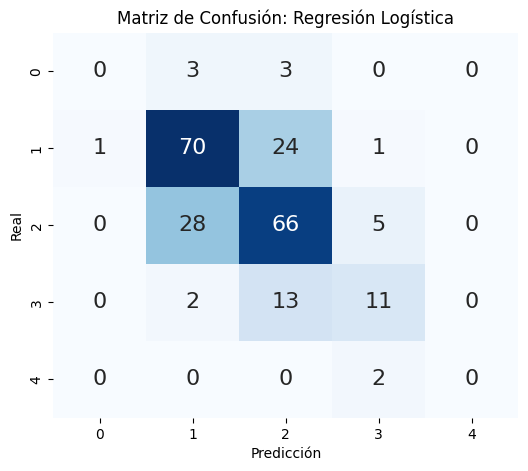


Reporte de clasificación para Regresión Logística:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.68      0.73      0.70        96
           3       0.62      0.67      0.64        99
           4       0.58      0.42      0.49        26
           5       0.00      0.00      0.00         2

    accuracy                           0.64       229
   macro avg       0.38      0.36      0.37       229
weighted avg       0.62      0.64      0.63       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [64]:
best_log_reg = grid_search_log_reg.best_estimator_
# Realizar predicciones con el modelo Regresión Logística final
y_pred_log_reg_final = best_log_reg.predict(X_test_scaled)

# Métricas de rendimiento
accuracy_log_reg_final = accuracy_score(y_test, y_pred_log_reg_final)
precision_log_reg_final = precision_score(y_test, y_pred_log_reg_final, average='weighted')
recall_log_reg_final = recall_score(y_test, y_pred_log_reg_final, average='weighted')
f1_log_reg_final = f1_score(y_test, y_pred_log_reg_final, average='weighted')

# Mostrar resultados
print(f"Precisión del modelo Regresión Logística: {accuracy_log_reg_final:.4f}")
print(f"Precisión ponderada (Regresión Logística): {precision_log_reg_final:.4f}")
print(f"Recall ponderado (Regresión Logística): {recall_log_reg_final:.4f}")
print(f"F1-Score ponderado (Regresión Logística): {f1_log_reg_final:.4f}")

# Matriz de confusión
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_final)
print(f"Matriz de Confusión (Regresión Logística):\n{cm_log_reg}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.title('Matriz de Confusión: Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación para Regresión Logística:")
print(classification_report(y_test, y_pred_log_reg_final))

In [65]:
# Realizar predicciones con el modelo KNN final
y_pred_knn_final = best_knn.predict(X_test_scaled)

# Generar el informe de clasificación para KNN
print("\nInforme de Clasificación para KNN:")
print(classification_report(y_test, y_pred_knn_final))


Informe de Clasificación para KNN:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.67      0.70      0.68        96
           3       0.56      0.63      0.59        99
           4       0.39      0.27      0.32        26
           5       0.00      0.00      0.00         2

    accuracy                           0.59       229
   macro avg       0.32      0.32      0.32       229
weighted avg       0.57      0.59      0.58       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [66]:
# Realizar predicciones con el modelo Random Forest final
y_pred_rf_final = best_rf.predict(X_test_scaled)

# Generar el informe de clasificación para Random Forest
print("\nInforme de Clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf_final))


Informe de Clasificación para Random Forest:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.72      0.78      0.75        96
           3       0.66      0.68      0.67        99
           4       0.70      0.62      0.65        26
           5       0.00      0.00      0.00         2

    accuracy                           0.69       229
   macro avg       0.41      0.41      0.41       229
weighted avg       0.67      0.69      0.68       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [67]:
# Realizar predicciones con el modelo Regresión Logística final
y_pred_log_reg_final = best_log_reg.predict(X_test_scaled)

# Generar el informe de clasificación para Regresión Logística
print("\nInforme de Clasificación para Regresión Logística:")
print(classification_report(y_test, y_pred_log_reg_final))


Informe de Clasificación para Regresión Logística:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.68      0.73      0.70        96
           3       0.62      0.67      0.64        99
           4       0.58      0.42      0.49        26
           5       0.00      0.00      0.00         2

    accuracy                           0.64       229
   macro avg       0.38      0.36      0.37       229
weighted avg       0.62      0.64      0.63       229



/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [72]:
# Obtener las probabilidades de predicción para el modelo Random Forest
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]  # Para la clase positiva (usualmente la clase 1)
# Calcular la curva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
# Calcular el AUC
auc_rf = auc(fpr_rf, tpr_rf)
# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'ROC Curve (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)
plt.title('Curva ROC para Random Forest')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


ValueError: multiclass format is not supported

In [73]:
# Obtener las probabilidades de predicción para el modelo KNN
y_prob_knn = best_knn.predict_proba(X_test_scaled)[:, 1]  # Para la clase positiva (usualmente la clase 1)

# Calcular la curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)

# Calcular el AUC
auc_knn = auc(fpr_knn, tpr_knn)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='green', label=f'ROC Curve (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)
plt.title('Curva ROC para KNN')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: multiclass format is not supported

In [74]:
# Obtener las probabilidades de predicción para el modelo Regresión Logística
y_prob_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]  # Para la clase positiva (usualmente la clase 1)

# Calcular la curva ROC
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_prob_log_reg)

# Calcular el AUC
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='red', label=f'ROC Curve (AUC = {auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)
plt.title('Curva ROC para Regresión Logística')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: multiclass format is not supported

In [75]:
# Obtener las probabilidades de predicción para cada modelo
y_prob_knn = best_knn.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
y_prob_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva ROC para cada modelo
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)

# Calcular el AUC para cada modelo
auc_knn = auc(fpr_knn, tpr_knn)
auc_rf = auc(fpr_rf, tpr_rf)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Visualización de la curva ROC para los tres modelos
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='red', label=f'Regresión Logística (AUC = {auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)

# Mejorar la visualización
plt.title('Comparación de Curvas ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: multiclass format is not supported

### 5. Análisis y Comparación de Resultados:

* Comparar el rendimiento de los diferentes modelos.
* Discutir cuál modelo ofrece el mejor rendimiento y por qué.
* Identificar las fortalezas y debilidades de cada enfoque en este contexto.

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Función para calcular las métricas de rendimiento
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' para tratar clases desbalanceadas
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Exactitud: {accuracy:.4f}")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Imprimir el informe de clasificación
    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\nMatriz de Confusión:")
    print(cm)

# Evaluar KNN
print("Evaluación del modelo KNN:")
evaluate_model(y_test, y_pred_knn_final)

# Evaluar Random Forest
print("\nEvaluación del modelo Random Forest:")
evaluate_model(y_test, y_pred_rf_final)

# Evaluar Regresión Logística
print("\nEvaluación del modelo Regresión Logística:")
evaluate_model(y_test, y_pred_log_reg_final)


Evaluación del modelo KNN:
Exactitud: 0.5939
Precisión: 0.5687
Recall: 0.5939
F1-Score: 0.5792

Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.67      0.70      0.68        96
           3       0.56      0.63      0.59        99
           4       0.39      0.27      0.32        26
           5       0.00      0.00      0.00         2

    accuracy                           0.59       229
   macro avg       0.32      0.32      0.32       229
weighted avg       0.57      0.59      0.58       229


Matriz de Confusión:
[[ 0  4  2  0  0]
 [ 1 67 27  1  0]
 [ 0 28 62  9  0]
 [ 0  1 18  7  0]
 [ 0  0  1  1  0]]

Evaluación del modelo Random Forest:
Exactitud: 0.6900
Precisión: 0.6653
Recall: 0.6900
F1-Score: 0.6768

Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.72      0.78 

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

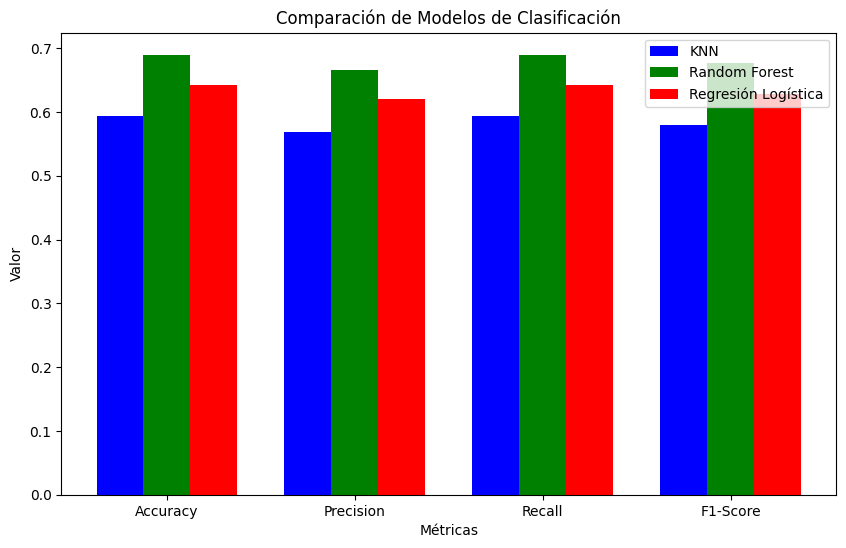

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Definir las métricas a comparar
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Métricas para cada modelo
knn_metrics = [
    accuracy_score(y_test, y_pred_knn_final),
    precision_score(y_test, y_pred_knn_final, average='weighted'),
    recall_score(y_test, y_pred_knn_final, average='weighted'),
    f1_score(y_test, y_pred_knn_final, average='weighted')
]

rf_metrics = [
    accuracy_score(y_test, y_pred_rf_final),
    precision_score(y_test, y_pred_rf_final, average='weighted'),
    recall_score(y_test, y_pred_rf_final, average='weighted'),
    f1_score(y_test, y_pred_rf_final, average='weighted')
]

log_reg_metrics = [
    accuracy_score(y_test, y_pred_log_reg_final),
    precision_score(y_test, y_pred_log_reg_final, average='weighted'),
    recall_score(y_test, y_pred_log_reg_final, average='weighted'),
    f1_score(y_test, y_pred_log_reg_final, average='weighted')
]

# Crear un gráfico de barras para comparar las métricas
x = np.arange(len(metrics))  # Posiciones de las métricas
width = 0.25  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para cada modelo
ax.bar(x - width, knn_metrics, width, label='KNN', color='b')
ax.bar(x, rf_metrics, width, label='Random Forest', color='g')
ax.bar(x + width, log_reg_metrics, width, label='Regresión Logística', color='r')

# Añadir etiquetas y título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Modelos de Clasificación')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Mostrar el gráfico
plt.show()


Curva ROC para KNN:


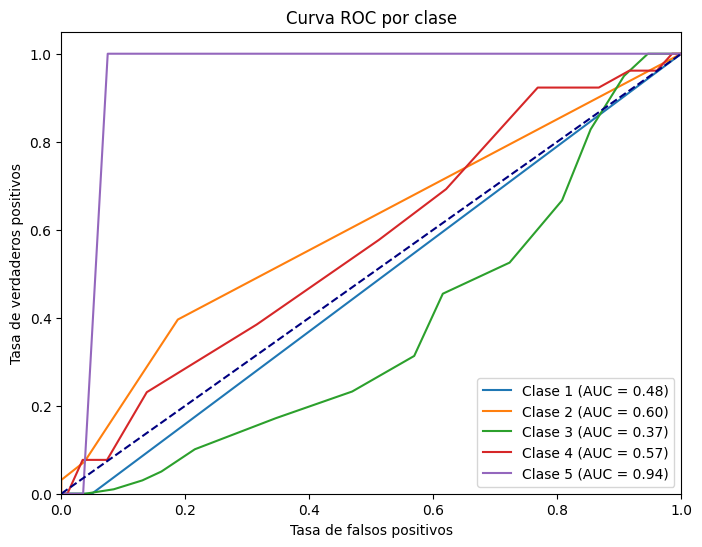

Curva ROC para Random Forest:


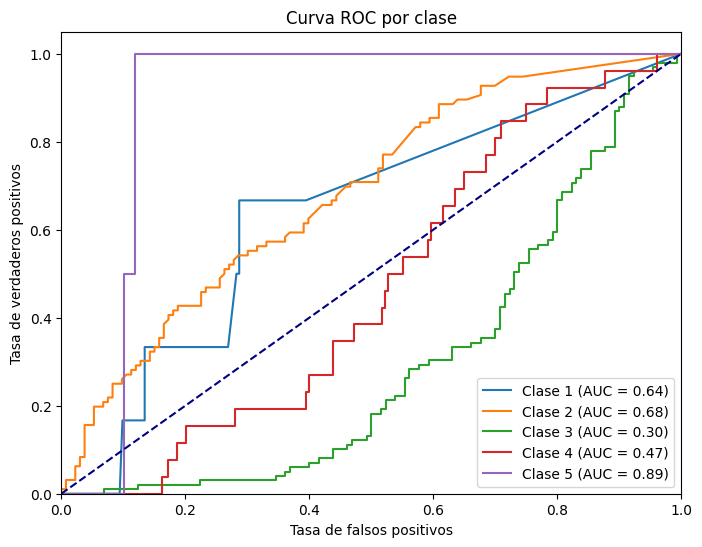

Curva ROC para Regresión Logística:


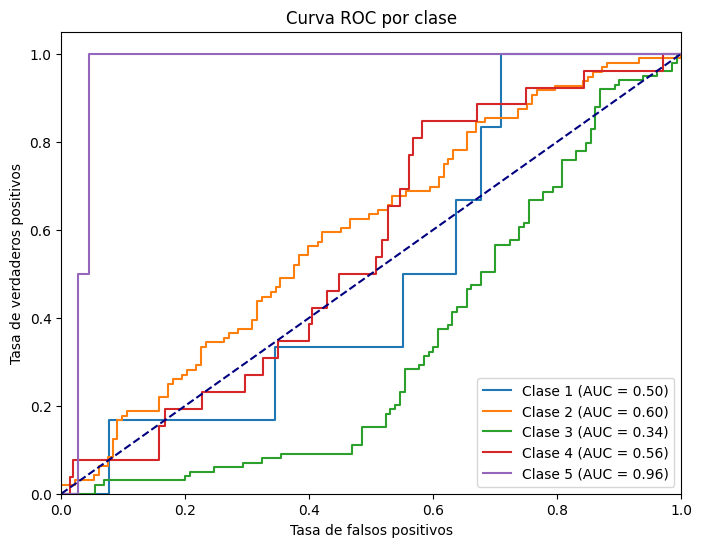

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Si tienes más de dos clases, binariza las etiquetas
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Para cada modelo, calcula las probabilidades y traza la curva ROC
def plot_roc_curve(model, X_test, y_test_bin):
    y_prob = model.predict_proba(X_test)
    
    # Inicializar el gráfico de la curva ROC
    plt.figure(figsize=(8, 6))
    
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Clase {i+1} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Línea diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC por clase')
    plt.legend(loc='lower right')
    plt.show()

# Graficar la curva ROC para cada modelo
print("Curva ROC para KNN:")
plot_roc_curve(best_knn, X_test_scaled, y_test_bin)

print("Curva ROC para Random Forest:")
plot_roc_curve(best_rf, X_test_scaled, y_test_bin)

print("Curva ROC para Regresión Logística:")
plot_roc_curve(best_log_reg, X_test_scaled, y_test_bin)
